In [1]:
%%capture
import sys
#sys.path.append("../../smt_modules")
sys.path.insert(0, "../../")
import glob, os
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi
import smt_modules.tools as tools

import pandas as pd
import netCDF4 as nc
import xarray as xr    
from dask.diagnostics import ProgressBar
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload
import matplotlib.patches as patches
from matplotlib import colors

In [43]:
#Reload modules:
reload(eva)
reload(tools)

Load my smt functions


<module 'smt_modules.tools' from '/home/m/m300878/submesoscaletelescope/notebooks/october22/../../smt_modules/tools.py'>

In [4]:
lon_reg_R0 = [-80.5, -55]
lat_reg_R0 = [25, 40]
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
fig_path = '/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/front/streamfunction/'
lon_reg = lon_reg_R0
lat_reg = lat_reg_R0
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

In [5]:
time_averaged = ''

#calculate MLD
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/t{time_averaged}.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/s{time_averaged}.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
data_t_mean  = pyic.interp_to_rectgrid_xr(t_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_s_mean  = pyic.interp_to_rectgrid_xr(s_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_rho_mean = gsw.rho(data_s_mean.S001_sp, data_t_mean.T001_sp, depthc[2])
mld_monte, mask_monte, mldx_monte = eva.calc_mld_montegut_xr(data_rho_mean, depthc)
mld, mask, mldx = eva.calc_mld_xr(data_rho_mean, depthc)
mld_mask = mask.transpose('depthc', 'lat', 'lon')
mld_mask = mld_mask.rename(depthc='depthi') #TODO

#calculate Ri
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/bx{time_averaged}.nc'
dbdx_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/by{time_averaged}.nc'
dbdy_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2{time_averaged}.nc'
n_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
n2_dselect = data_n2_mean.sel(depthi=slice(depthi[0], depthi[111])) 
data_M2_mean = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))
data_M2_ymean = data_dbdy_mean.sel(depthi=slice(depthi[0], depthi[111]))
data_M2_xmean = data_dbdx_mean.sel(depthi=slice(depthi[0], depthi[111]))

ri_mean = eva.calc_richardsonnumber(data_n2_mean.lat, data_n2_mean, data_M2_ymean)

#Average over mld M2, Ri, wb
M2_dselect = data_M2_mean.sel(depthi=slice(depthi[0], depthi[111]))
M2x_dselect = data_M2_xmean.sel(depthi=slice(depthi[0], depthi[111]))
M2y_dselect = data_M2_ymean.sel(depthi=slice(depthi[0], depthi[111]))

M2x_mld = M2x_dselect  * mld_mask.data
M2x_mld = M2x_mld.where(M2x_mld !=0) #zeros to nans
M2x_mld_mean = M2x_mld.mean(dim='depthi', skipna=True)

M2y_mld = M2y_dselect  * mld_mask.data
M2y_mld = M2y_mld.where(M2y_mld !=0) #zeros to nans
M2y_mld_mean = M2y_mld.mean(dim='depthi', skipna=True)

M2_mld = M2_dselect  * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0) #zeros to nans
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)

n2_mld = data_n2_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
n2_mld = n2_mld.where(n2_mld !=0) #zeros to nans

ri_dselect = ri_mean.sel(depthi=slice(depthi[0], depthi[111])) #ri_mean[:112]
ri_mld = ri_dselect * mld_mask.data #Todo. check if error to big because mld mask is on depthc
ri_mld = ri_mld.where(ri_mld != 0) #zeros to nans
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb{time_averaged}_prime.nc'
wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')
data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week
wb_dselect = data_wb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) 
wb_mld = wb_dselect * mld_mask.data
wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)


In [ ]:
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/vb{time_averaged}_prime.nc'
vb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
vb_prime_mean = vb_prime_mean.rename(__xarray_dataarray_variable__='vb_prime_mean')
data_vb_prime_mean  = pyic.interp_to_rectgrid_xr(vb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week
vb_dselect = data_vb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) 
vb_mld = vb_dselect * mld_mask.data
vb_mld = vb_mld.where(wb_mld != 0) #neglect zeros in average
vb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)

In [ ]:
grad_b = eva.calc_grad_b(m2x=0, m2y=m2y , n2=n2)

In [15]:
argo = eva.load_argo_climatology()

In [37]:
def plot_slice_front(x, y, lhs, alpha, wb, ri, mldx, mldx_monte, argo_mld, rho, m2, dl, ylim=None, title=None, fig_path=None, savefig=False):
    """plot vertical parameters of front"""
    fig, ax = plt.subplots(1, 1, figsize=(20,7), sharey=True)
    lw = 4
    color= 'r'
    ls='dashed'
    fs=25
    depth_s = 83

    m2=-np.abs(m2)
    psi = eva.calc_streamfunc_held_schneider(wb, m2)
    psi = psi.isel(depthi=slice(0,depth_s))

    grad_b   = eva.calc_grad_b(m2x=0, m2y= m2y, n2=n2)
    psi_held = eva.calc_streamfunc_full_held_schneider(wb, m2, vb, n2, grad_b)
    psi_traditional = eva.calc_streamfunc(vb,n2)

    levels = np.linspace(-5,5, 15)
    cf = ax.contourf(x, psi.depthi, psi.data, levels, cmap='PiYG_r', extend='both')
    
    cb = fig.colorbar(cf, ax=ax)
    levels = np.linspace(1025,1027,120)
    ax.contour(x, rho.depthc, rho.data, levels, colors='gray', label='rho contour')
    ax.plot([], [], 'grey', label="Isopycnal")
    ax.plot(x, mldx, color=color, linewidth=lw, linestyle=ls, label='MLD rho=0.2')
    ax.plot(x, mldx_monte, color='purple', linewidth=lw, linestyle=ls, label='MLD rho=0.03')
    ax.axhline(argo_mld, color='tab:green', ls=ls, linewidth=lw, label=f'MLD Argo monthly {int(argo_mld)}m')
    ax.axvline(wb.lat[0]+dl, color='black')
    ax.axvline(wb.lat[-1]-dl, color='black')
    ax.legend(loc='lower right')
    ax.set_ylim(ylim)
    ax.set_title("$ \psi = - w'b'/~ -abs(db/dy) $",fontsize=fs)
    ax.set_xlabel(f"{title}")

    # if savefig == True: plt.savefig(fig_path, dpi=150, format='png', bbox_inches='tight')


In [38]:

def eval_front(lon_front, lat_front, front, dl):
    ylim =500,0

    lat_mean = eva.mean_help(lat_front)
    lon_mean = eva.mean_help(lon_front)
    argo_mld = argo.mld_da_mean.isel(iLAT=int(lat_mean), iLON=int(lon_mean), iMONTH=3)

    M2y_masked = M2y_dselect.where(M2y_dselect < -5e-9, np.nan)
    wb_fselect, ri_fselect, mldx_fselect, mldx_monte_fselect, m2x_fselect, m2y_fselect, alpha_fselect, lhs_fselect, rho_fselect, n2_fselect = eva.calc_front_varaibles(wb_dselect, ri_dselect, mldx, mldx_monte, M2x_dselect, M2y_masked, data_rho_mean, data_n2_mean, lon_front, lat_front, dim='lon', ave=True)
    path = f'{fig_path}Slice_wide_ag22.png'
    title = f"crossfront slice, alongfront averaged over mld of {front}"
    plot_slice_front(x=alpha_fselect.lat, y=alpha_fselect.depthi, lhs=lhs_fselect, alpha=alpha_fselect, 
                    wb=wb_fselect, ri=ri_fselect, mldx=mldx_fselect, mldx_monte=mldx_monte_fselect, argo_mld=argo_mld, rho=rho_fselect, m2=m2y_fselect, dl=dl,
                    ylim=ylim, title=title, fig_path=path, savefig=True)


Load my smt functions
/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/front/streamfunction/Slice_wide_ag22.png


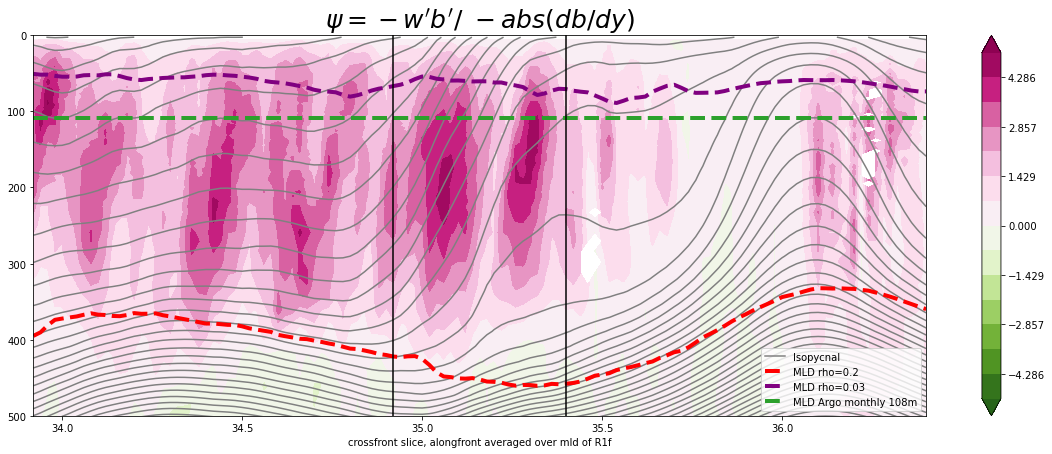

In [39]:
reload(eva)
lon_reg_all, lat_reg_all = eva.get_fronts()
for ii in np.arange(1):
    #ii=4
    front =             f'R{ii+1}f'
    lon_front = lon_reg_all[ii,:]
    lat_front = lat_reg_all[ii,:]

    ##plot slice sections
    dl=1
    lat_front[1] = lat_front[1] + dl
    lat_front[0] = lat_front[0] - dl

    eval_front(lon_front , lat_front, front, dl)
    # break